In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler
from datetime import datetime
from pyspark.sql.types import DateType,StringType,IntegerType, DoubleType
from pyspark.ml.feature import VectorAssembler, Binarizer, Bucketizer, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import CountVectorizer,Tokenizer,StopWordsRemover,IDF
from pyspark.ml.classification import NaiveBayes, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import seaborn as sns 
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from sklearn.covariance import EllipticEnvelope
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.clustering import GaussianMixture
import scipy.stats as stats
import math

In [2]:
# Filepaths
train_fp = '/FileStore/tables/RS_v2_2006_03.json' # train set
test_fp = '/FileStore/tables/RS_v2_2006_04.json' # test set or OOT set depending on what results you want to check

# Loading original datasets
df_train_original = spark.read.json(train_fp)
df_test_original = spark.read.json(test_fp)

# Loading datasets to play with
df_train = spark.read.json(train_fp)
df_test = spark.read.json(test_fp)

In [3]:
# Looking at the distribution of scores and num_comments
columns = ["score", "num_comments"]
percentiles = [0.25, 0.5, 0.75, 0.9, 0.99]
quantiles = df_train.approxQuantile(col=columns, probabilities=percentiles, relativeError=0)
g = pd.DataFrame(dict(zip(columns, map(lambda x: dict(zip(percentiles, x)), quantiles))))
g.index.name = 'quantile'
g

# Looking at the plot of num_comments and score, most of the values clustered 
display(df_train.select("num_comments","score"))

num_comments,score
0,0
0,0
0,0
0,0
0,0
1,0
0,4
0,0
0,7
1,9


In [4]:
def filterOutliers(df, threshold=1.5, columns_to_filter=["score","num_comments"], output_column="outlier"):
  """Given a DataFrame, remove rows in which any feature
     or the label are far from the mean. 
    Args:
        df: a DataFrame 
        threshold: the distance from mean in units of standard deviations
                   outside of which to filter rows
    Returns:
        filtered DataFrame
  """
  # filter based on score:
  for c in columns_to_filter:
    labelMean = df.rdd.map(lambda row: row[c]).mean()
    labelStd = df.rdd.map(lambda row: row[c]).stdev()  
    
    upper_bound = labelMean+threshold*labelStd
    lower_bound = labelMean-threshold*labelStd

    df = df.withColumn(output_column + "_" + c, when((col(c) < upper_bound) & (col(c) > lower_bound), 0).otherwise(1))
  
  # If columns have either of the columns that violate the standard deviation threhsolds, classify them to be filtered out
  columns_to_combine = list(map(lambda x: output_column+"_"+x,columns_to_filter))
  expression = '+'.join(columns_to_combine)
  df = df.withColumn(output_column, expr(expression)).withColumn(output_column, when(col(output_column) > 0, 1).otherwise(0))
        
  df = df.drop(*columns_to_combine)
  
  return df

In [5]:
# Fuction to apply the Elliptic Envelope method to filter outliers
# users input a PySpark dataframe and a contamination (percentage of outliers) and get output 
# a dataframe with a boolean column, outlier stating whether the row is an outlier or not
def filter_elliptical(df, contamination=0.05):
  X = df.select("num_comments","score").toPandas()
  cov = EllipticEnvelope(contamination=contamination, random_state=1234).fit(X)
  wh = (np.where(cov.predict(X) == -1)[0] + 1).tolist()

  w = Window().partitionBy(lit('a')).orderBy(lit('a'))
  df = df.withColumn("row_num", row_number().over(w))
  df = df.withColumn("outlier", when(col("row_num").isin(wh), 1).otherwise(0))
  
  df = df.drop("row_num")
  
  return df

In [6]:
# Set a percentage of outliers to filter
pc_to_filter = 0.01

# Applying the function
df_train = filter_elliptical(df_train, contamination=pc_to_filter)
pc_removed = df_train.select(sum("outlier")).collect()[0][0]*100/df_train.count()
print("Percentage of Dataset Removed:", pc_removed)

Percentage of Dataset Removed: 1.0059880239520957

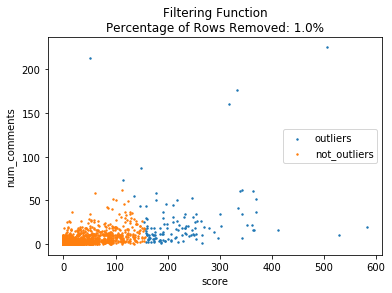

In [7]:
# Visualizing filter function
outliers = df_train.filter(col("outlier") == 1).toPandas()
not_outliers = df_train.filter(col("outlier") == 0).toPandas()

# Plotting
plt.scatter(outliers['score'],outliers['num_comments'], s=2, label='outliers')
plt.scatter(not_outliers['score'], not_outliers['num_comments'], s=2, label='not_outliers')
plt.legend()
plt.xlabel("score")
plt.ylabel("num_comments")
plt.title(f"Filtering Function\nPercentage of Rows Removed: {pc_removed:.1f}%")

In [8]:
# # Filtering based on the outlier column
# # df_train = df_train.filter(col("outlier") == 0)

# we abandoned outlier fitering so we drop the column that was created
df_train = df_train.drop("outlier")

In [9]:
# Drop these columns because url is random, permalink has the following structure (subreddit_prefix/comments/ID/title) which is already accessible through other features in dataset
# There are 7 distinct thumbnails, but they're mostly empty
#'subreddit_id' and 'subreddit_name_prefixed' have same value with 'subreddit', so I only keep 'subreddit'
# id: it's a unique identifier

columns_to_drop = {'permalink','thumbnail','subreddit_id','subreddit_name_prefixed','id'}

# Removing the columns from the training set
df_train = df_train.drop(*columns_to_drop)

In [10]:
def count_missings(spark_df,sort=True):
    """
    Return the percentage of missing value in each column
    Args:
        df: a DataFrame 
        sort: whether or not sort the dataframe based on percentage of missing value
    """
    for c in spark_df.dtypes:
      if "array" in c[1] and c[0]!="preview":
        spark_df = spark_df.withColumn(c[0], when((size(col(c[0])) == 0), lit(None)).otherwise(col(c[0])))
        
    df = spark_df.select([(count(when(col(c).isNull(), c))*100/count(lit(1))).alias(c) for c in df_train.columns]).toPandas() # dealing with all other columns
    df.at[0,'selftext']=spark_df.select([count(when(col('selftext')=="",True))*100/count(lit(1))]).collect()[0][0]; # dealing with the selftext column
    if sort:
        return df.rename(index={0: 'Percentage'}).T.rename_axis('Feature', axis=1).sort_values("Percentage",ascending=False)

    return df

In [11]:
# Compute the missing values
df_missingValue = count_missings(df_train)

# Create a dataframe of missing values
df_missingValue = sqlContext.createDataFrame(df_missingValue.reset_index(drop=False))
display(df_missingValue)

index,Percentage
secure_media,100.0
media,100.0
link_flair_css_class,100.0
link_flair_richtext,100.0
author_flair_css_class,100.0
author_flair_richtext,100.0
author_flair_text,100.0
link_flair_text,100.0
distinguished,100.0
preview,99.96007984031937


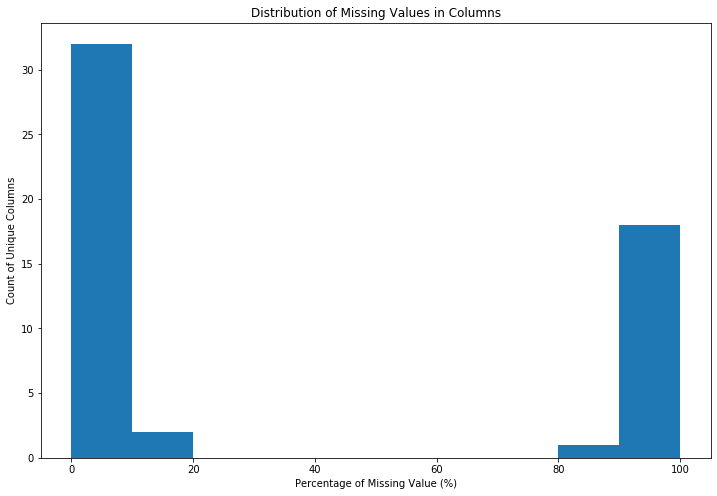

In [12]:
# Plot a histogram of missing values
plt.figure(figsize=(12,8))
plt.hist(df_missingValue.toPandas()['Percentage'])
plt.xlabel("Percentage of Missing Value (%)")
plt.ylabel("Count of Unique Columns")
plt.title("Distribution of Missing Values in Columns")

# This plot shows that there's two distinct groups based on the histogram, which is the basis for our decision to remove 
# columns with less than 20% missing values in the next step
# We can change this plot later if needed

In [13]:
# Creating variables of columns to keep and drop based on the 20% missing value threshold
columns_to_keep = df_missingValue.filter(df_missingValue.Percentage <= 20).select("index")
columns_to_keep = [row['index'] for row in columns_to_keep.collect()] # converting to list

columns_to_drop = df_missingValue.filter(df_missingValue.Percentage > 20).select("index")
columns_to_drop = [row['index'] for row in columns_to_drop.collect()]

print("Columns to keep:", columns_to_keep)
print("\nColumns to drop:", columns_to_drop)

Columns to keep: ['whitelist_status', 'parent_whitelist_status', 'author_flair_type', 'send_replies', 'score', 'spoiler', 'stickied', 'over_18', 'rte_mode', 'subreddit_type', 'title', 'url', 'subreddit', 'archived', 'num_crossposts', 'num_comments', 'brand_safe', 'can_gild', 'contest_mode', 'created_utc', 'domain', 'edited', 'gilded', 'hidden', 'hide_score', 'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video', 'author', 'link_flair_type', 'locked', 'no_follow', 'link_flair_text_color']

Columns to drop: ['secure_media', 'media', 'link_flair_css_class', 'link_flair_richtext', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_text', 'link_flair_text', 'distinguished', 'preview', 'post_hint', 'thumbnail_width', 'thumbnail_height', 'author_cakeday', 'retrieved_on', 'selftext', 'author_flair_text_color', 'author_flair_background_color', 'suggested_sort']

In [14]:
df_train = df_train.drop(*columns_to_drop)

In [15]:
# Selecting columns to impute by filtering the columns_to_keep that have missing values greater than 0
columns_to_impute = df_missingValue.filter((df_missingValue.index.isin(list(columns_to_keep))) & (df_missingValue.Percentage > 0)).select("index")
columns_to_impute = [row['index'] for row in columns_to_impute.collect()] # converting to list
print("Columns to Impute:",columns_to_impute)

# None of these columns null values should be imputed because of reasons below:
# whitelist status: whether or not you've enabled a whitelist on reddit (if null, you don't have that set up. So null should become a different category i.e. don't have whitelist status)
# parent whitelist status: same as above, null should become a new category
# author_flair_type: We should change the intepretation of this. People who have null do not have any flair displayed near their name. Seems like it's either text or null in both train and test sets
# So, we should create a separate concept for this

Columns to Impute: ['whitelist_status', 'parent_whitelist_status', 'author_flair_type']

In [16]:
df_train = df_train.fillna("None", subset=columns_to_impute)

In [17]:
def singleValueFeatures(spark_df,min_=1):
  """Given a DataFrame, remove column which all rows have same value.
    Args:
        df: a DataFrame 
        min: lower bound for the count of distinct values in each column
    Returns:
        filtered DataFrame
  """
  df = spark_df.agg(*(countDistinct(col(c)).alias(c) for c in spark_df.columns)).toPandas()
  df=df.rename(index={0: 'Count'}).T.rename_axis('Feature', axis=1).sort_values("Count",ascending=True)
  df= sqlContext.createDataFrame(df.reset_index(drop=False))
  singleValueFeature=df.filter(df.Count <= min_).select('index').rdd.map(lambda row : row[0]).collect()
  
  return singleValueFeature

In [18]:
# We need to do this step after filling the NA as we did in the section above
# This is because this function would get rid of author_flair_type because it has one unique value, text (in reality, null should be counted as a unique value)
columns_to_drop = singleValueFeatures(df_train)

# Dropping the single value columns
df_train = df_train.drop(*columns_to_drop)

In [19]:
# Selecting same columns and filling the NA for the columns to impute with None
df_test = df_test.select(df_train.columns).fillna("None", subset=columns_to_impute)

In [20]:
def engineer_date(df):
  # Casting created UTC to timestamp 
  df = df.withColumn('created_timestamp',from_unixtime(col('created_utc'),'yyyy-MM-dd HH:mm:ss.SS').cast("timestamp"))
  
  # Extract the month, the day of the week (Sunday starts at 1), and the hour of creation
  df = df.withColumn('created_hour', hour(df.created_timestamp))\
  .withColumn('created_day', dayofweek(df.created_timestamp))\
  .drop(*['created_timestamp','created_utc'])
  
  return df

In [21]:
def engineer_url(df, regex_cleaning="(http://)|(https://)|(www.)|(\.[a-z]+|(\/\d+)|(\/id))|(\?.*+)", in_column = "url", out_column = "cleaned_url", drop_url = True):
  # Regular expressions to find hyphens, slashes and underscores
  regexp_hyundslash = "(\/)|(-)|(_)"
  regex_reddit = "(\.reddit\.)"
  
  # Line 1: lower the url column
  # Line 2: take the .reddit and turn it into _reddit. because later, we remove any characters that follow a .
  # Line 3: we replace the matched to regex cleaning with nothing
  # Line 4: replace hyphens and slashes with white space
  df = df.withColumn(out_column, F.lower(col(in_column))) \
  .withColumn(out_column, regexp_replace(col(out_column), regex_reddit, "_reddit.")) \
  .withColumn(out_column, regexp_replace(col(out_column), regex_cleaning , "")) \
  .withColumn(out_column, regexp_replace(col(out_column), regexp_hyundslash, " ")) \
  .withColumn(out_column, F.trim(col(out_column)))
  
  if drop_url:
    df = df.drop(in_column)
  
  return df

# You can inspect the URL cleaner with the code below, change the row number and you can see the URL and the cleaned URL
# row_no = 412
# engineer_url(df_train, drop_url=False).select("url","cleaned_url").collect()[row_no]

In [22]:
def engineer_subdomauth(df):
  # Windows partitioned over each column
  windowSpec_subreddit = Window.partitionBy("subreddit")
  windowSpec_domain = Window.partitionBy("domain")
  windowSpec_author = Window.partitionBy("author")

  # Creating new columns with the subreddit/domain/author average for each row
  df = df.withColumn("subreddit_avg", F.avg("num_comments").over(windowSpec_subreddit)) \
  .withColumn("domain_avg", F.avg("num_comments").over(windowSpec_domain))\
  .withColumn("author_avg", F.avg("num_comments").over(windowSpec_author))\
  .drop(*['subreddit','domain','author'])
  
  return df

In [23]:
# Combining all functions in one function
def apply_engineering(df):
  df = engineer_subdomauth(df)
  df = engineer_url(df)
  df = engineer_date(df)
  
  return df

# Applying feature engineering to train and test sets
df_train = apply_engineering(df_train)
df_test = apply_engineering(df_test)

In [24]:
# Good reference here for Word2Vec and TF-IDF https://spark.apache.org/docs/latest/mllib-feature-extraction.html#word2vec
def createPipeline(input_col, num_features=30):
  '''
  Function takes an input column and a number of features of the word embedding space
  and returns a TF-IDF pipeline for that column and a list of columns that need to be
  dropped after applying the pipeline
  '''
  # Initialize the objects
  tokenizer = Tokenizer(inputCol = input_col, outputCol = input_col + "_tokens")
  hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol= input_col + '_embedded', numFeatures=num_features)
  idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol= input_col + "_features")
  
  # Create a PySpark pipeline
  pipeline = Pipeline(stages = [tokenizer, hashingTF, idf])
  
  # Make a list of the columsn created in the pipeline that need to be dropped
  cols_to_drop = [tokenizer.getOutputCol(), hashingTF.getOutputCol(), input_col]
  
  return pipeline, cols_to_drop

def runTextPipeline(df_tr, df_te, input_col, num_features=30):
  '''
  This function takes a train and test set, an input column and the numver of features
  of the word embedding space and applies a TF-IDF pipeline to it
  '''
  pipeline, cols_to_drop = createPipeline(input_col, num_features)
  
  # Fit on train
  pl = pipeline.fit(df_tr)
  
  # Trasnform train
  df_tr = pl.transform(df_tr)
  
  # Transform test
  df_te = pl.transform(df_te)
  
  # Drop the random columns created
  df_tr = df_tr.drop(*cols_to_drop)
  df_te = df_te.drop(*cols_to_drop)
  
  return df_tr, df_te

In [25]:
# Applying the string embedding
df_train, df_test = runTextPipeline(df_train, df_test, "title")
df_train, df_test = runTextPipeline(df_train, df_test, "cleaned_url")

In [26]:
# Adding a columns called score_g_zero which will be used in the Stage 1 classifier later
df_train = df_train.withColumn('score_g_zero', when(col('score')==0, 0).otherwise(1))
df_test =  df_test.withColumn('score_g_zero', when(col('score')==0, 0).otherwise(1))

# Adding a columns called score_g_zero which will be used in the Stage 1 classifier later
df_train_original = df_train_original.withColumn('score_g_zero', when(col('score')==0, 0).otherwise(1))
df_test_original =  df_test_original.withColumn('score_g_zero', when(col('score')==0, 0).otherwise(1))

In [27]:
# Define helper functions
def plot_normal_distribution(mu, var, weight):
  sigma = math.sqrt(var)
  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100000)
  plt.plot(x, (stats.norm.pdf(x, mu, sigma) * weight))

def solve(m1, m2, var1, var2, w1, w2):
  # Solve intersection points between two weighted gaussian distributions
  std1 = np.sqrt(var1)
  std2 = np.sqrt(var2)
  a = -1/(var1) + 1/(var2)
  b = 2*(m1/(var1) - m2/(var2))
  c = m2**2/var2 - m1**2/var1 + np.log(var2/var1)
  c = c + (2 * np.log(w1/w2))
  return np.roots([a,b,c])

In [28]:
# Fit GMM model
df_train = df_train.drop('PROBABILITY', 'PREDICTION', 'rawPrediction').drop('score_vec').drop('score_cluster').drop('comment_avg_vec').drop('comment_avg_cluster')

score_assembler = VectorAssembler(inputCols=['score'], outputCol="score_vec")
df_train = score_assembler.transform(df_train)

score_gm = GaussianMixture(featuresCol = 'score_vec', predictionCol = 'score_cluster', k = 10, tol = 0.001, seed = 1) # the first two values of intersect_x in the next cell should be 0, 0.28, 1.43. If not, try seed = 4242. We noticed this was an issue when running the notebook on different user accounts
score_model = score_gm.fit(df_train)

#df_train = score_model.transform(df_train)
df_train = df_train.drop('score_vec')

In [29]:
weights = []
mean = []
var = []

for i in range(score_model.getK()):
  mean.append(score_model.gaussians[i].mean.toArray()[0])
  var.append(score_model.gaussians[i].cov.toArray()[0][0])
  weights.append(score_model.weights[i])

weights = np.array(weights)
mean = np.array(mean)
var = np.array(var)

score_dis_df = score_model.gaussiansDF.toPandas()
score_dis_df['weights'] = weights
score_dis_df['mean'] = mean
score_dis_df['cov'] = var
score_dis_df = score_dis_df.sort_values(by = 'mean', ignore_index=True)

intersect_x = []
score_dis_df['intersect_x'] = np.zeros(10)
for i in range(score_dis_df.shape[0] - 1):
  intersect_x.append(solve(score_dis_df['mean'][i], score_dis_df['mean'][i+1], score_dis_df['cov'][i], score_dis_df['cov'][i+1], score_dis_df['weights'][i], score_dis_df['weights'][i+1]))
intersects = np.amax(intersect_x, axis=1)
score_dis_df['intersect_x'][1:10] = intersects # If this errors out, refer to the seed comment in the cell above
score_dis_df.head(10)

,mean,cov,weights,intersect_x
0,4.889945e-09,0.000003,0.598403,0.000000
1,1.000000e+00,0.000018,0.091655,0.281654
2,2.000000e+00,0.000032,0.052360,1.430915
3,3.321857e+00,0.221887,0.050116,2.022978
4,4.971653e+00,0.736294,0.045770,4.065916
5,7.269201e+00,2.274553,0.041034,6.152689
6,1.132412e+01,9.614777,0.034689,9.472413
7,2.270875e+01,61.260954,0.032763,16.349174
8,6.941650e+01,1020.171772,0.036767,37.516838
9,1.784493e+02,8339.769190,0.016443,132.964645


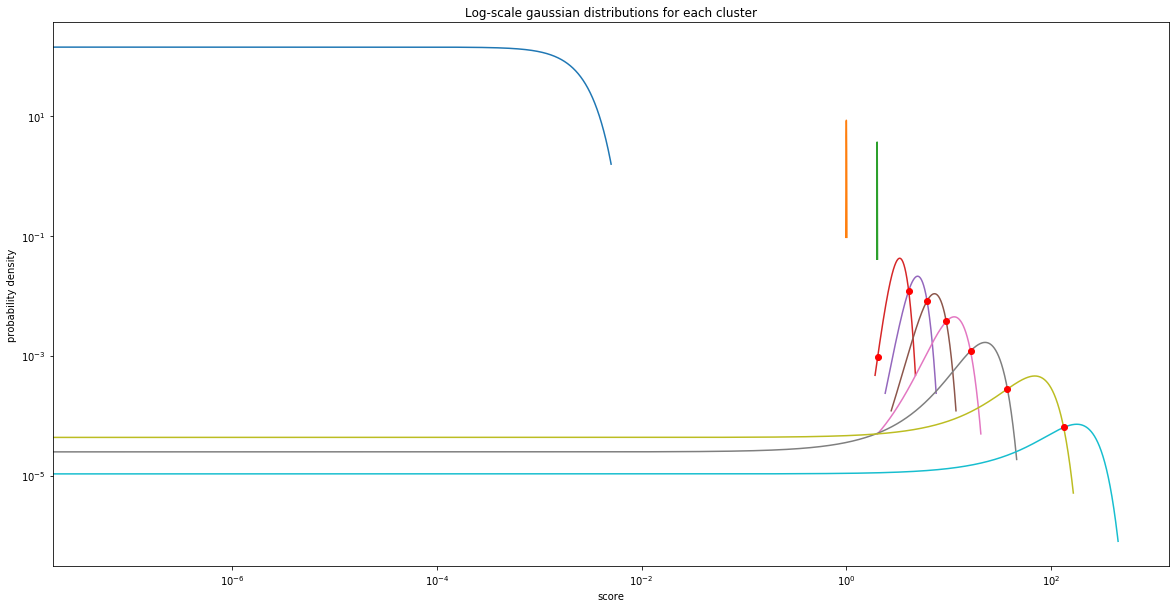

In [30]:
# Plot distributions and intersection points
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.xscale('log')
plt.title('Log-scale gaussian distributions for each cluster')
plt.xlabel('score')
plt.ylabel('probability density')
for i in range(score_dis_df.shape[0]):
  plot_normal_distribution(score_dis_df['mean'][i], score_dis_df['cov'][i], score_dis_df['weights'][i])
for i in range(intersects.shape[0]):
  plt.plot(intersects[i], stats.norm.pdf(intersects[i], score_dis_df['mean'][i+1], np.sqrt(score_dis_df['cov'][i+1])) * score_dis_df['weights'][i+1],'ro')
plt.show()

In [31]:
# Category function that was used
def category_func2(score):
  if score <=2:
    return score
  elif score>=3 and score <=4:
    return 3
  elif score>=5 and score <=6:
    return 4
  elif score>=7 and score <=9:
    return 5
  elif score>=10 and score <=16:
    return 6
  elif score>=17 and score <=37:
    return 7
  elif score>=38 and score <=133:
    return 8
  else:
    return 9
category_func = udf(category_func2)
df_train = df_train.withColumn("Categories", category_func(df_train.score).cast(IntegerType()))
df_test = df_test.withColumn("Categories", category_func(df_test.score).cast(IntegerType()))

df_train_original = df_train_original.withColumn("Categories", category_func(df_train_original.score).cast(IntegerType()))
df_test_original = df_test_original.withColumn("Categories", category_func(df_test_original.score).cast(IntegerType()))

In [32]:
# Binary columns 
string_binary_columns = ['author_flair_type']
bool_binary_columns = ['over_18','brand_safe','can_gild', 'no_follow','is_crosspostable']

# Categorical columns
categorical_columns = ['parent_whitelist_status', 'whitelist_status', 'subreddit_type','created_hour', 'created_day']

# Numerical columns
numerical_columns = ['num_comments','subreddit_avg','domain_avg','author_avg']

# String Columns
string_columns = ['title','cleaned_url']

In [34]:
def plot(df_train):
  score_buckets_reverse1 = {    
  0:'0',
  1:'1',
  2:'2',
  3:'3-4', 
  4:'5-6', 
  5:'7-9',
  6:'10-16',
  7:'17-37', 
  8:'38-133', 
  9:'>133'
  }
  
  score_buckets_reverse2 = {    
  0:'Zero',
  1:'Non-zero'
  }
  # histogram of scores
  import matplotlib.pyplot as plt
  from math import log
  npts =df_train.count()
  scores = df_train.select('score').collect()#.take(npts)
  scores_01=df_train.select('score_g_zero').collect()
  scores_category=df_train.select('Categories').collect()

  score_original = [float(y[0]) for y in scores]
  score_01 = [float(y[0]) for y in scores_01]
  score_category= [float(y[0]) for y in scores_category]

  buckets1=[""]*len(score_buckets_reverse1)
  for i in range(0,len(score_buckets_reverse1)):
    buckets1[i] = score_buckets_reverse1[i]

  buckets2=[""]*2
  for i in range(0,2):
    buckets2[i] = score_buckets_reverse2[i]

  f, axes = plt.subplots(2,2,figsize=(20,10),dpi=80, facecolor='w', edgecolor='k',num=None)
  f.tight_layout()
  f.subplots_adjust(hspace=0.2,wspace=0.2)
  axes[0][0].hist(score_original, bins=100, log=False)
  axes[0][0].set_title('Histogram of Scores')
  axes[0][0].set_ylabel('Count')
  axes[0][0].set_xlabel('Score')
  axes[0][1].hist(score_original, bins=100, log=True)
  axes[0][1].set_title('Log-Histogram of Scores')
  axes[0][1].set_ylabel('Log-Count')
  axes[0][1].set_xlabel('Score')

  sns.distplot(score_01,hist=True,bins=2,norm_hist=True,ax=axes[1, 0])
  loc1 = np.arange(start=0, stop=1.5, step=1/2)
  axes[1][0].set_xticks(loc1)
  axes[1][0].grid(True)
  axes[1][0].set_xticklabels(labels=buckets2,ha="left")
  axes[1][0].set_title('Distribution Plot of Zero and Non-zero Scores')
  axes[1][0].set_ylabel('Distribution (Density)')
  axes[1][0].set_xlabel('Score')

  sns.distplot(score_category,hist=True,bins=10,norm_hist=True,ax=axes[1][1])
  loc2 = np.arange(start=0, stop=9.90, step=9/10)
  axes[1][1].set_xticks(loc2)
  axes[1][1].grid(True)
  axes[1][1].set_xticklabels(labels=buckets1,ha="left")
  axes[1][1].set_title('Distribution Plot of Categorized Scores')
  axes[1][1].set_ylabel('Distribution (Density)')
  axes[1][1].set_xlabel('Score')
  display(f)

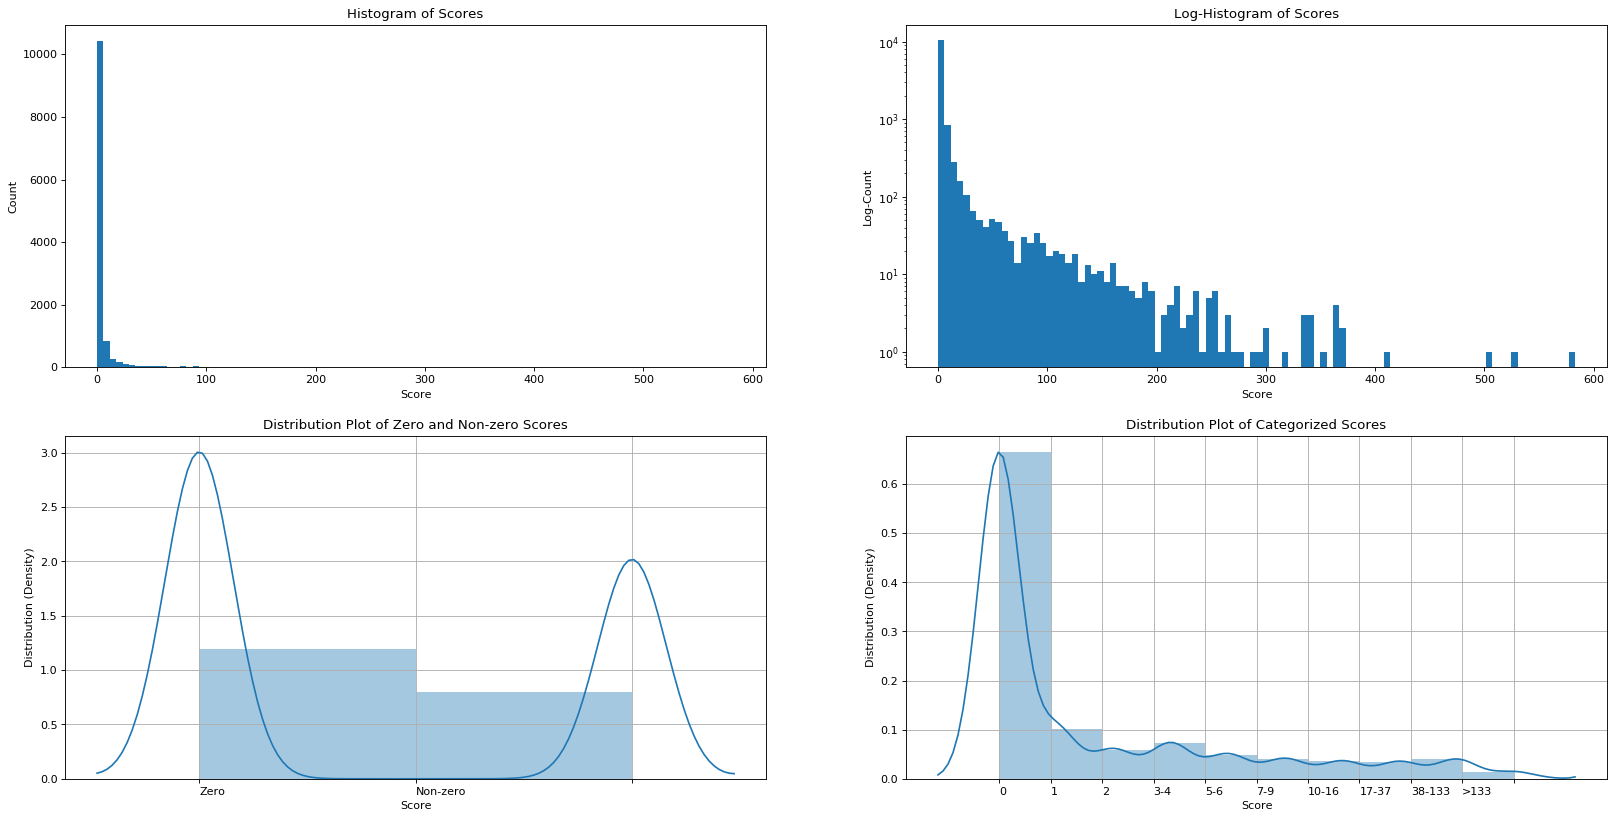

In [35]:
plot(df_train_original)

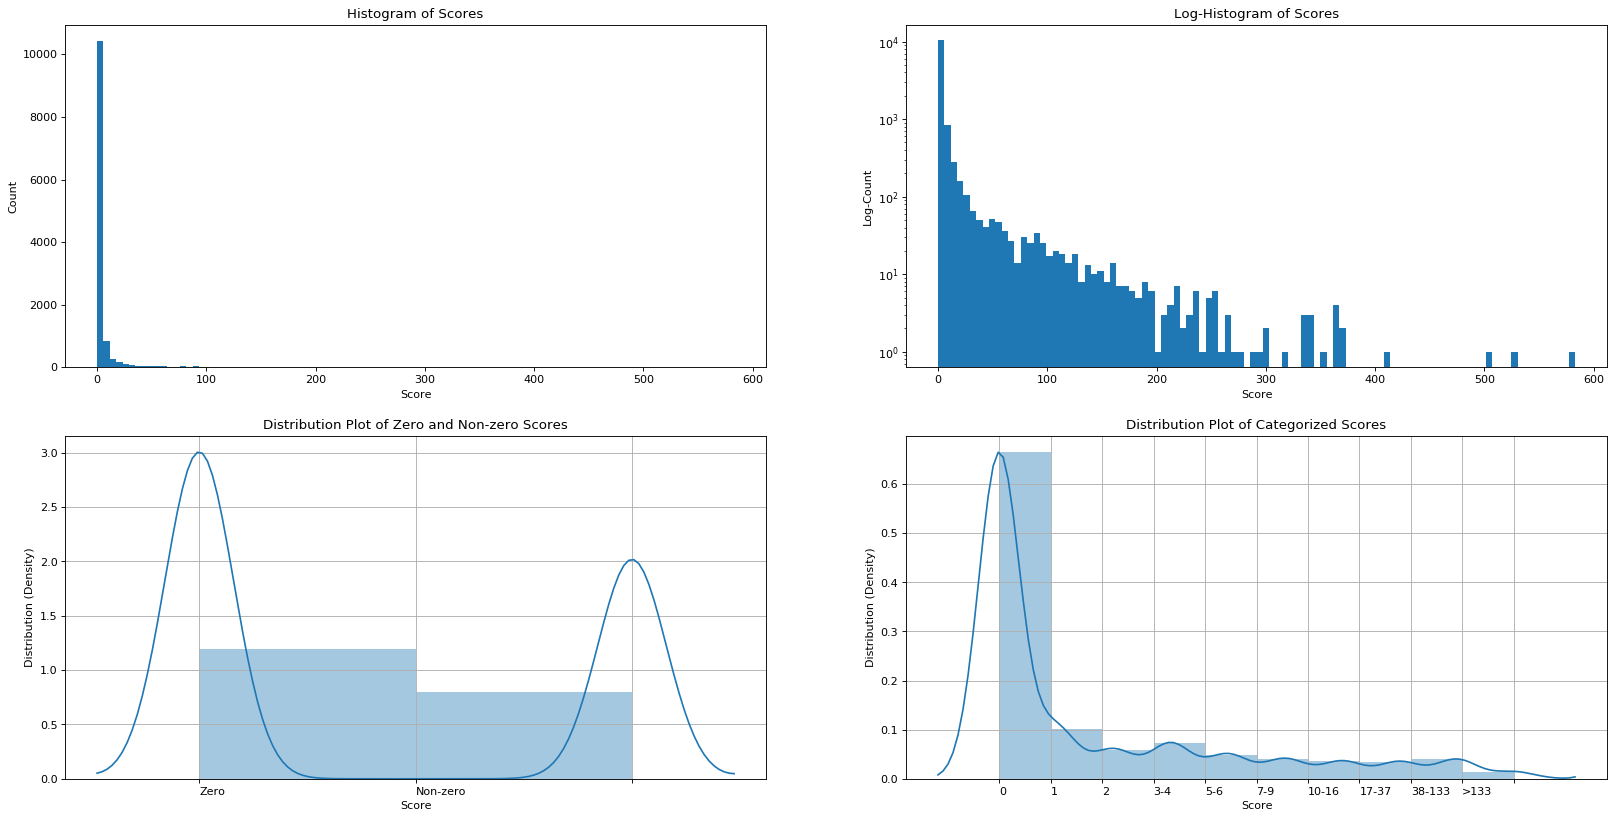

In [36]:
plot(df_train)

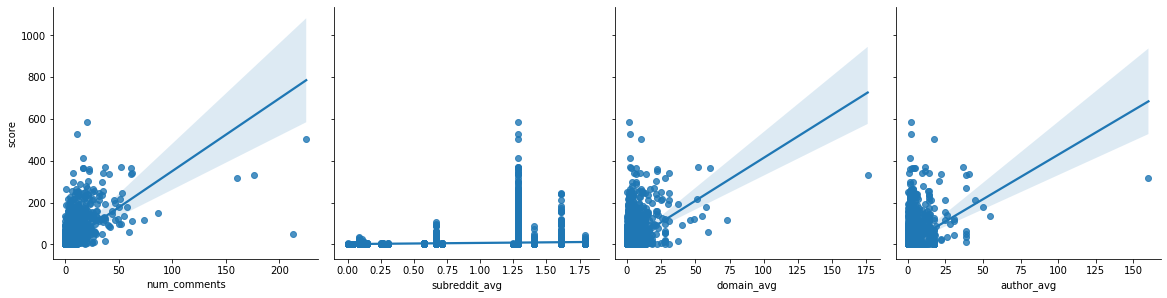

In [37]:
g = sns.PairGrid(df_train.toPandas(), y_vars=["score"], x_vars=numerical_columns, height=4)
g.map(sns.regplot)

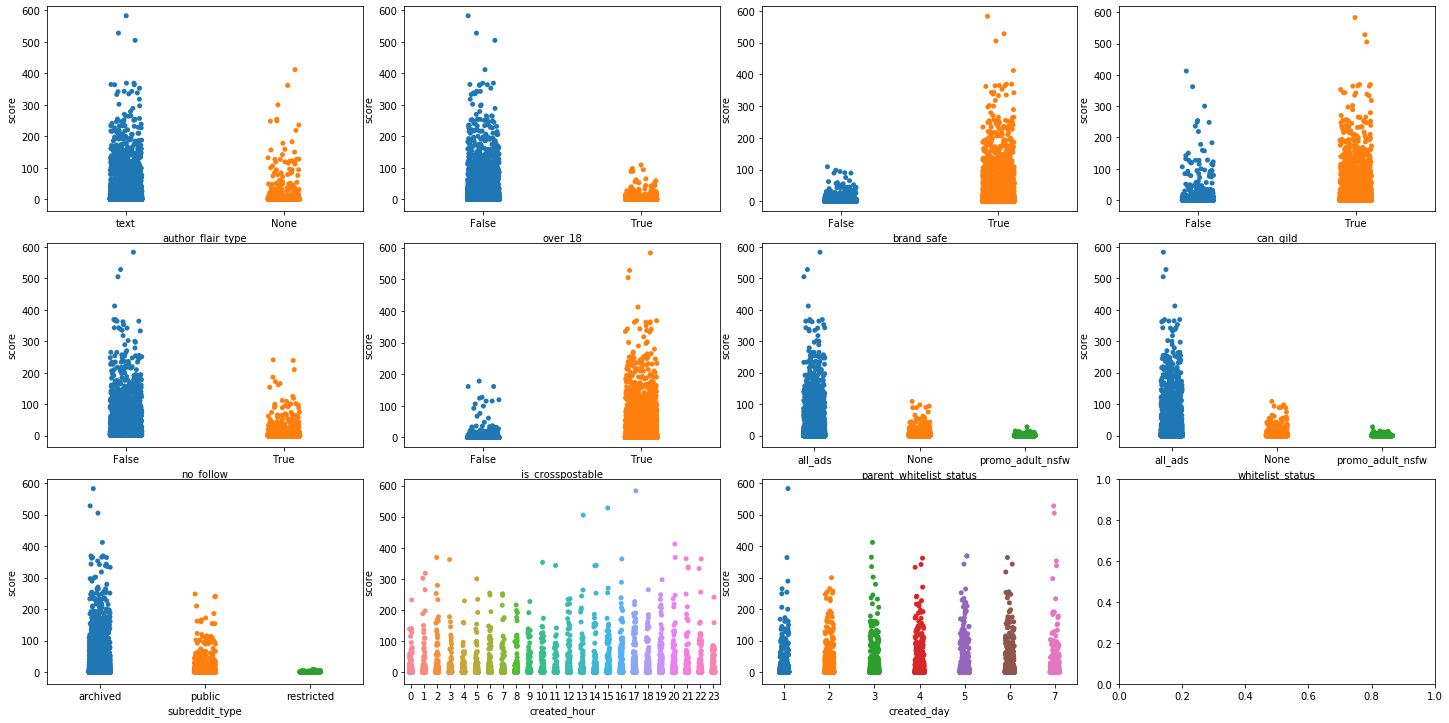

In [38]:
x_features=string_binary_columns+bool_binary_columns+categorical_columns
f, axes = plt.subplots(3,4,figsize=(20,10))
f.subplots_adjust(hspace=2,wspace=1)
f.tight_layout()
for i in range(0, len(x_features)):
  print(x_features[i])
  sns.stripplot(x=x_features[i], y='score', data=df_train.toPandas(),ax=axes[int(i/4)][i%4])
display(f)

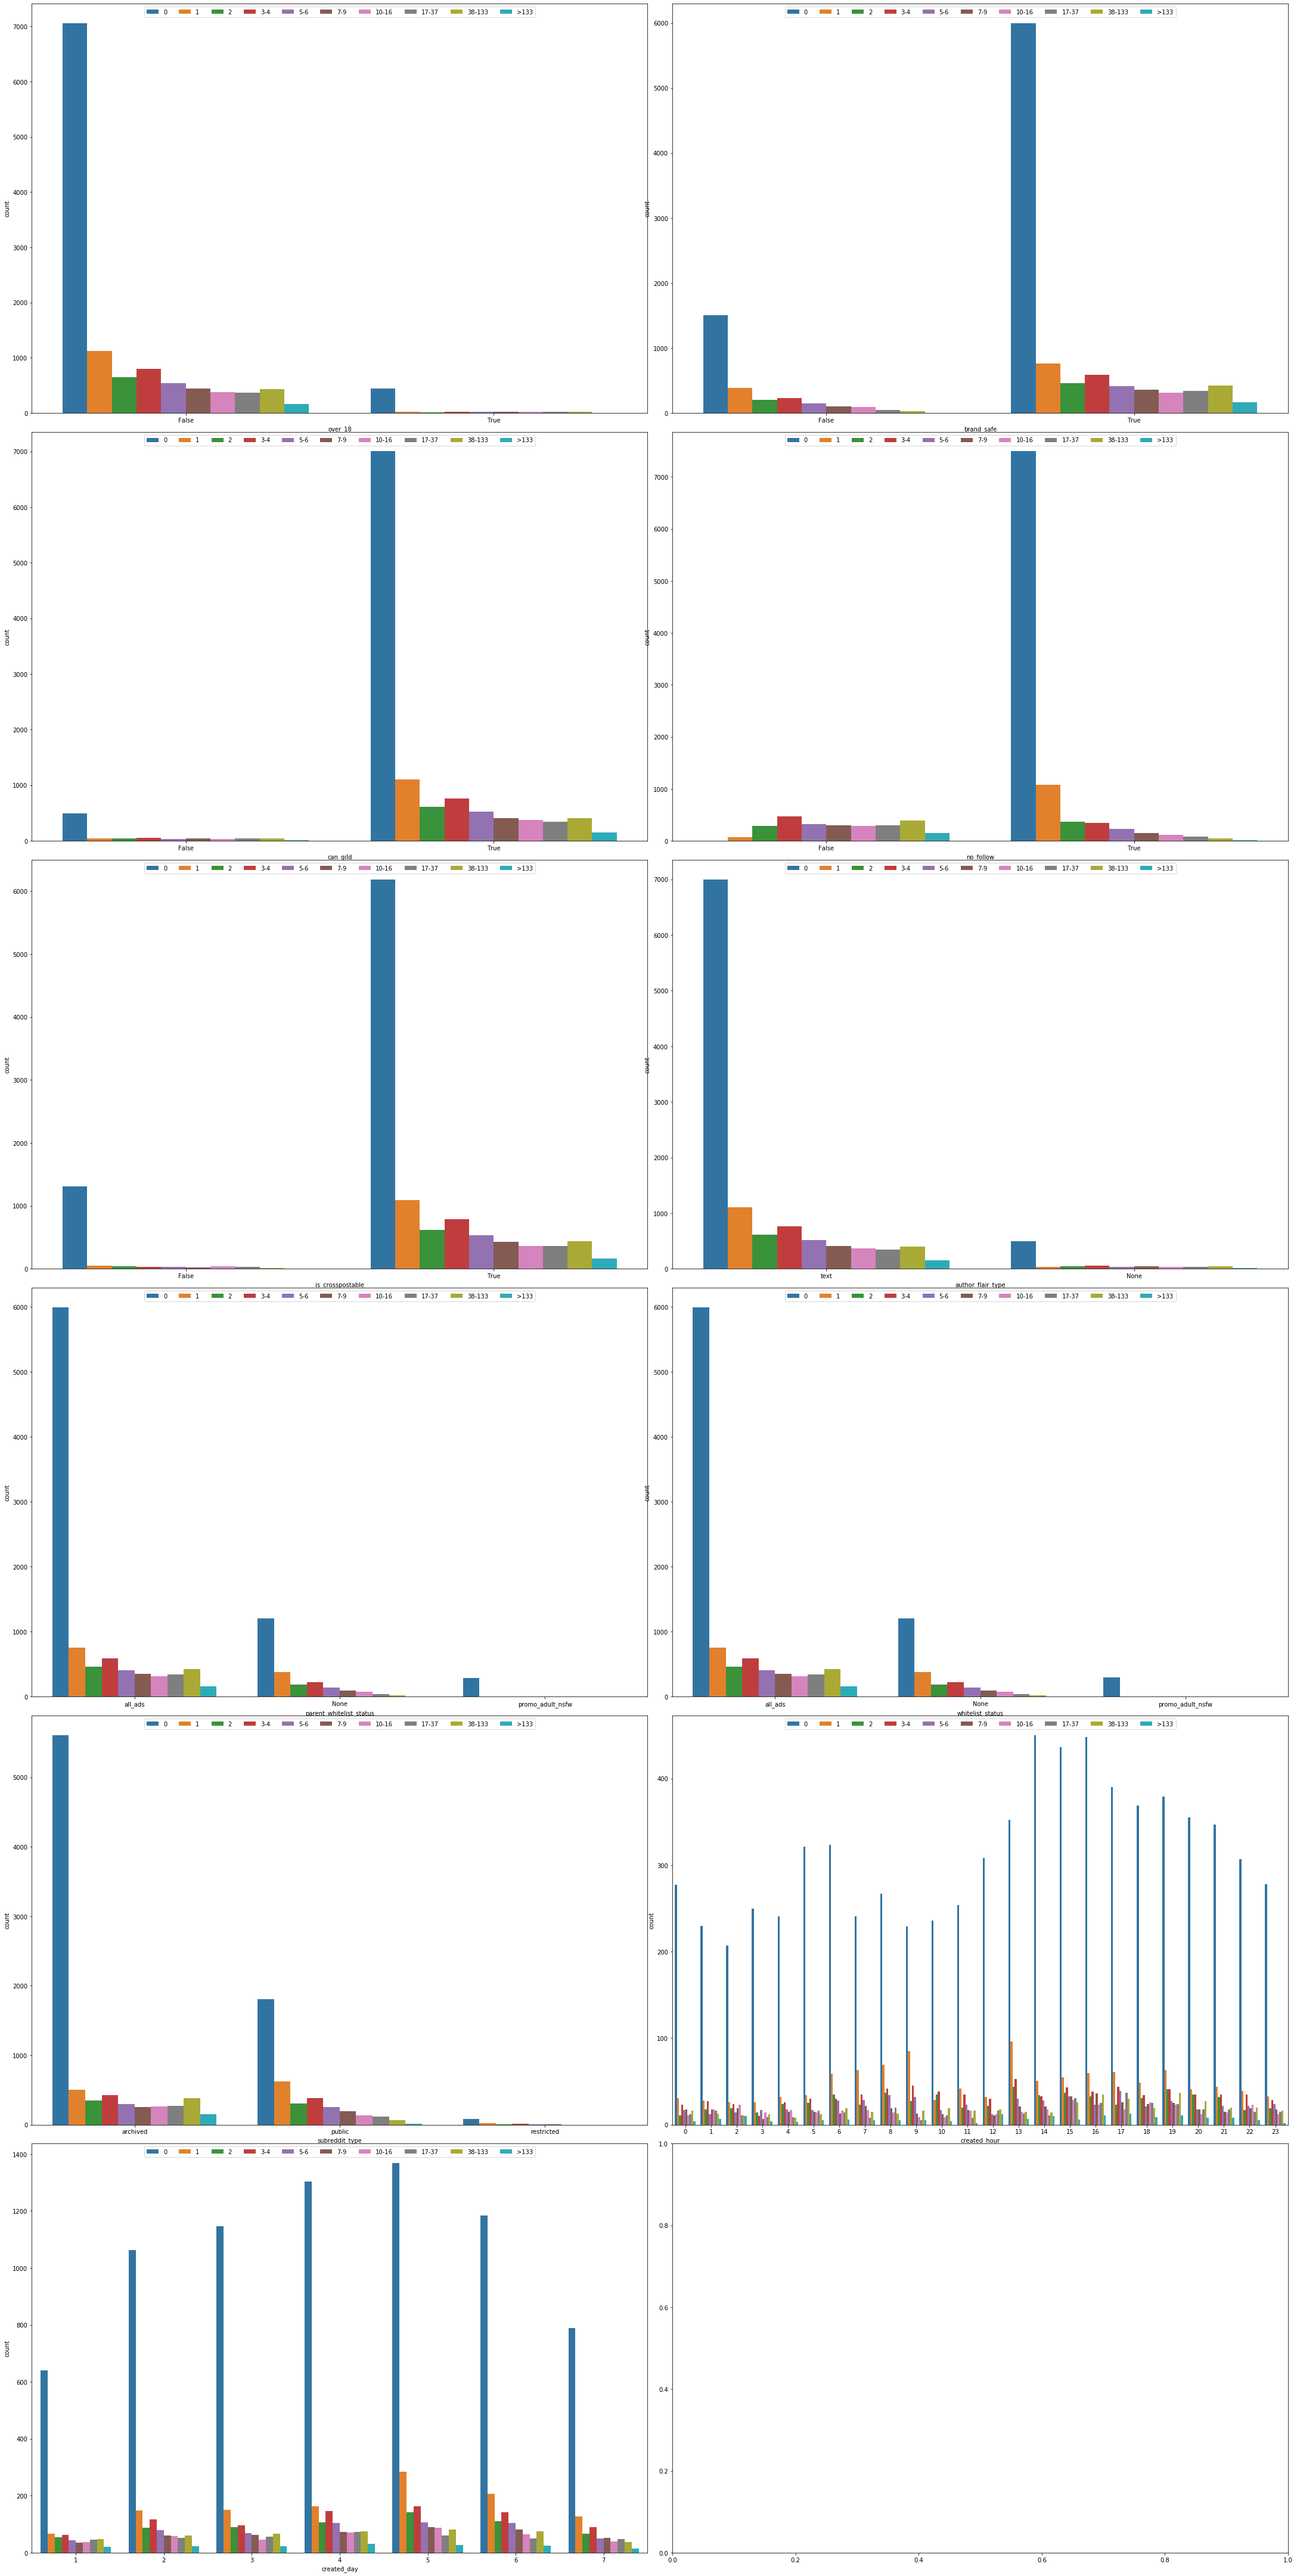

In [39]:
#We can see that some feature is helpful to distiguish zero score and non-zero score, like no_follow. If no_follow is false, the score is not likely to be zero. But it is difficult to classify non-zero score into right bucket. 
score_buckets=["0","1","2","3-4","5-6","7-9","10-16","17-37","38-133",">133"]

#columns=['over_18','brand_safe','can_gild', 'no_follow','is_crosspostable', 'author_flair_type', 'domain_bin', 'parent_whitelist_status', 'whitelist_status', 'subreddit_type','created_hour', 'created_day','bucketed_subreddit','bucketed_author']
columns=['over_18','brand_safe','can_gild', 'no_follow','is_crosspostable', 'author_flair_type','parent_whitelist_status', 'whitelist_status', 'subreddit_type','created_hour', 'created_day']
f, axes = plt.subplots(6,2,figsize=(30,60))
f.subplots_adjust(hspace=2,wspace=1)
f.tight_layout()
for i in range(0, len(columns)):
  sns.countplot(x=columns[i], hue = 'Categories', data=df_train.toPandas(),ax=axes[int(i/2)][i%2])
  axes[int(i/2)][i%2].legend(labels=score_buckets, loc='upper center', ncol=11)
display(f)

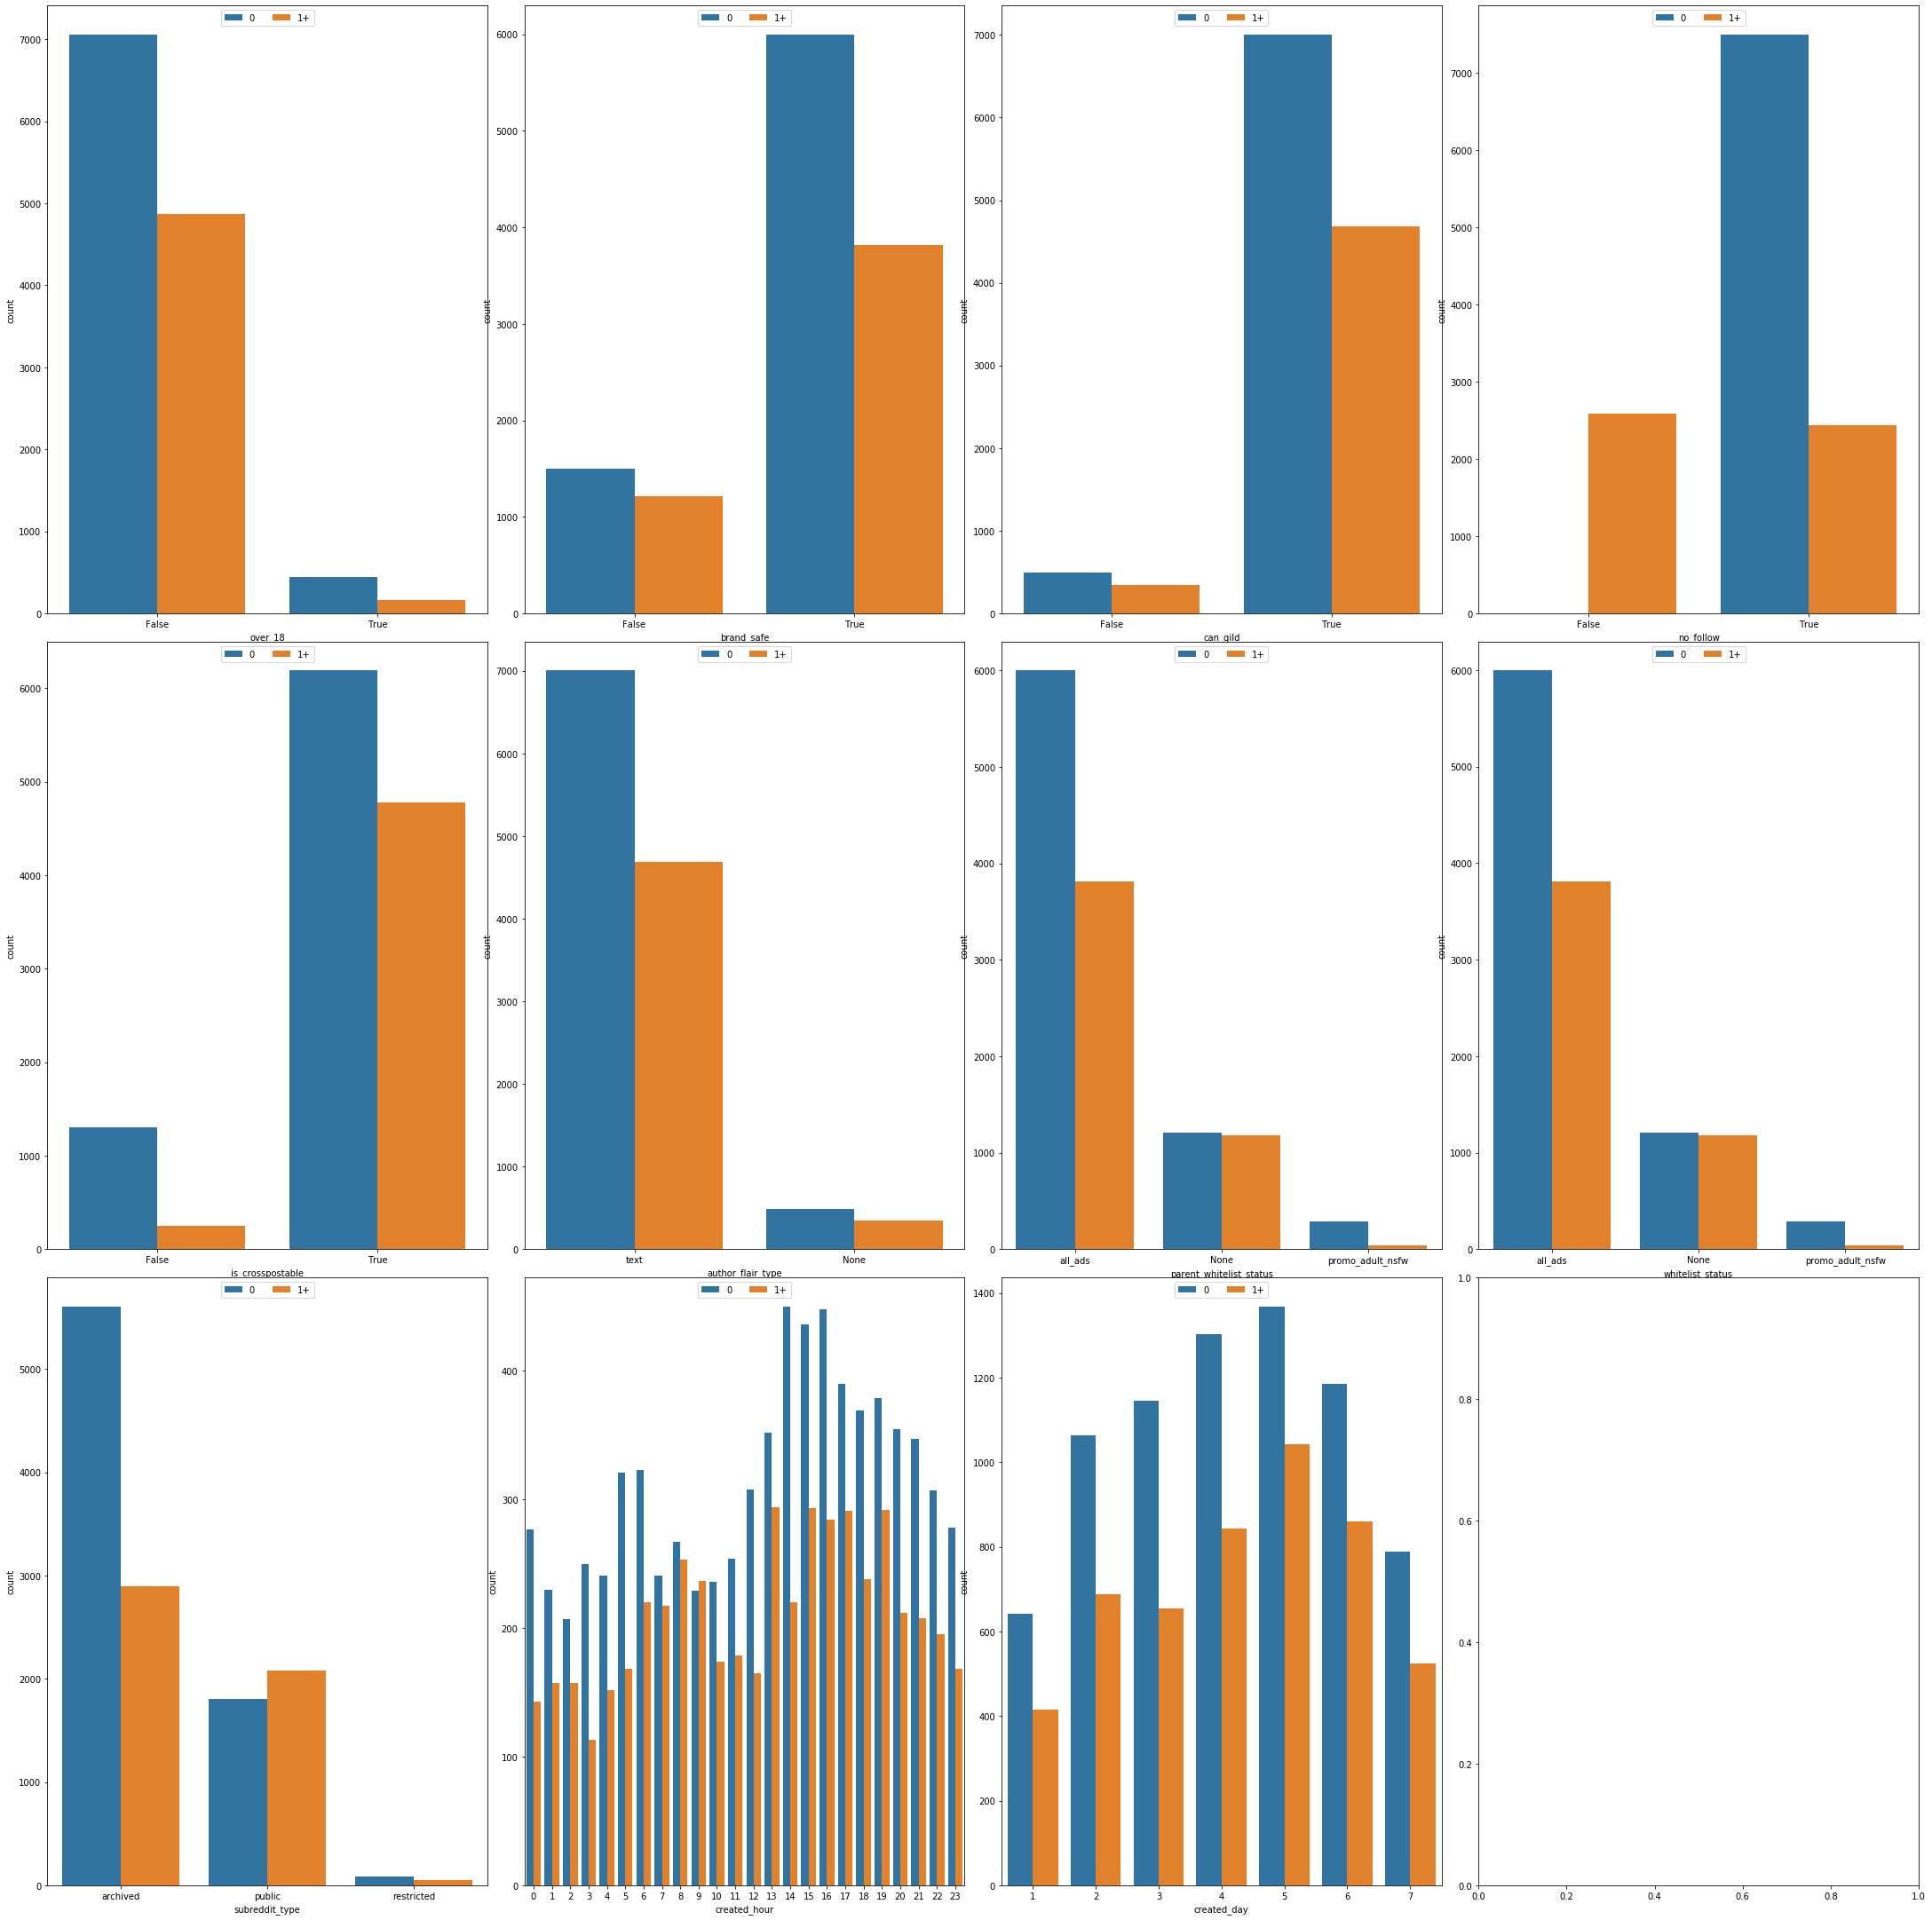

In [40]:
score_buckets=["0","1+"]
#columns=['over_18','brand_safe','can_gild', 'no_follow','is_crosspostable', 'author_flair_type', 'domain_bin', 'parent_whitelist_status', 'whitelist_status', 'subreddit_type','created_hour', 'created_day','bucketed_subreddit','bucketed_author']
columns=['over_18','brand_safe','can_gild', 'no_follow','is_crosspostable', 'author_flair_type','parent_whitelist_status', 'whitelist_status', 'subreddit_type','created_hour', 'created_day']
f, axes = plt.subplots(3,4,figsize=(30,30))
f.subplots_adjust(hspace=2,wspace=1)
f.tight_layout()
for i in range(0, len(columns)):
  sns.countplot(x=columns[i], hue = 'score_g_zero', data=df_train.toPandas(),ax=axes[int(i/4)][i%4])
  axes[int(i/4)][i%4].legend(labels=score_buckets, loc='upper center', ncol=11)
display(f)

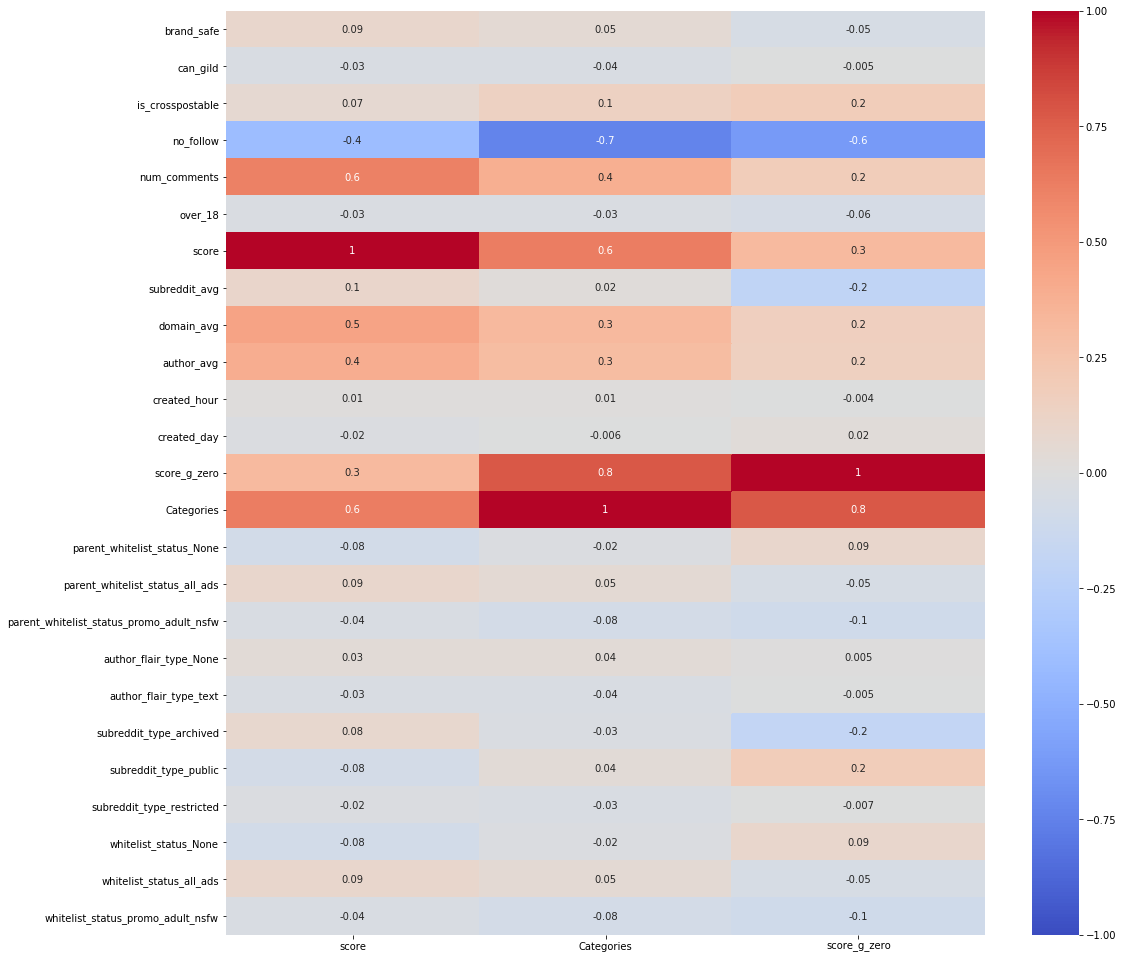

In [41]:
#Only use train_visualation to plot correlated matrix
train_visualation=df_train.toPandas()
DummyColumns = ['parent_whitelist_status','author_flair_type','subreddit_type','whitelist_status']
for col in DummyColumns:
    train_visualation= pd.get_dummies(data=train_visualation, columns=[col])
    
#In statistics, a perfect negative correlation is represented by the value -1, a 0 indicates no correlation, and a +1 indicates a perfect positive correlation. 
#Score: We can see that num_comments(0.6), domain_avg(0.5), author_avg(0.4) have a strong positive colrelation with score and no_follow(-0.4) has a strong positive colrelation with score.
#Score_g_zero:num_comment(0.2),no_follow(-0.6),is_crosspostable(0.2),subreddit_avg(-0.2),domain_avg(0.2),author_avg(0.2),subreddit_type(0.2)
#Categories: num_comment(0.4),no_follow(-0.7),domain_avg(0.3),author_avg(0.3)
plt.figure(figsize=(17,17))
sns.heatmap(train_visualation.corr()[['score','Categories','score_g_zero']], annot = True, fmt='.1g',vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.show()

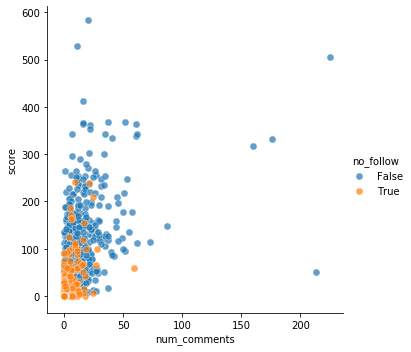

In [42]:
#If no_follow is false, the score is not likely to be zero. 
g = sns.FacetGrid(train_visualation, hue="no_follow", height=5)
g.map(plt.scatter, "num_comments", "score", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend();

In [43]:
def binarization(df_tr, df_te, columns):
  """Given a DataFrame, convert binary data to 0 or 1 data
    Args:
        df: a DataFrame 
        columns: list of columns needed to be converted
    Returns:
        Encoded DataFrame
  """   
  for c in columns:
    indexer = StringIndexer(inputCol=c, outputCol=c+"_bin")
    model = indexer.fit(df_tr)
    df_tr = model.transform(df_tr)
    df_te = model.transform(df_te)
  df_tr = df_tr.drop(*columns)
  df_te = df_te.drop(*columns)
    
  return df_tr, df_te

df_train, df_test = binarization(df_train, df_test, string_binary_columns)

In [44]:
from pyspark.sql.functions import col
def booleanToInteger(spark_df):
  """Given a DataFrame, conver the boolean type to integer type.
    Args:
        df: a DataFrame 
    Returns:
        Converted DataFrame
  """
  for c in spark_df.dtypes:
    if "boolean" in c[1]:
        spark_df = spark_df.withColumn(c[0], when(col(c[0]) == 'False', 0).otherwise(1))
  return spark_df

df_train = booleanToInteger(df_train)
df_test = booleanToInteger(df_test)

In [45]:
def oneHotEncoding(df, df_test, columns):
  """Given a DataFrame, convert categorical data to numerical data
    Args:
        df: a DataFrame 
        columns: list of columns needed to be converted
    Returns:
        Encoded DataFrame
  """
  for c in columns:
    indexer = StringIndexer(inputCol=c, outputCol=c+"_Vec")
    model_ = indexer.fit(df)
    df = model_.transform(df)
    df_test = model_.transform(df_test)
    
  inputColumn=[c+"_Vec" for c in columns]
  outputColumn=[c+"_Encoded" for c in columns]
  encoder = OneHotEncoder(inputCols=inputColumn,outputCols=outputColumn)
  model = encoder.fit(df)
  df = model.transform(df)
  df = df.drop(*columns).drop(*inputColumn)
  
  df_test = model.transform(df_test)
  df_test = df_test.drop(*columns).drop(*inputColumn)
  
  return df, df_test

df_train, df_test = oneHotEncoding(df_train, df_test, categorical_columns)

In [46]:
# Selecting all columns except score,Categories and score_g_zero
#inputC = list(set(df_filtered_train.columns) - {'score','Categories','score_g_zero'})

#Try to use features which have strong colrelation with score to train the model, we can also get 68% accuracy.
inputC=['brand_safe','can_gild','is_crosspostable','no_follow','num_comments','over_18','parent_whitelist_status_Encoded','subreddit_type_Encoded','whitelist_status_Encoded','subreddit_avg','domain_avg','author_avg','created_hour_Encoded','created_day_Encoded','author_flair_type_bin', 'title_features','cleaned_url_features']

# Assembling vectors into an output column called features
vector = VectorAssembler(inputCols = inputC, outputCol = "assembled_features")
scaler = StandardScaler(inputCol='assembled_features', outputCol='features',withStd=True, withMean=True)

assembling_pipeline = Pipeline(stages=[vector,scaler])

# Fitting the pipeline
fit_pipeline = assembling_pipeline.fit(df_train)

# Transforming the dataset
final_train = fit_pipeline.transform(df_train)
final_test = fit_pipeline.transform(df_test)

In [47]:
# Train set
train = final_train.select("Categories","score_g_zero","features")

# Test set
test = final_test.select("Categories","score_g_zero","features")

In [48]:
# Scaler object
scaler = StandardScaler(inputCol='features', outputCol='scaled_features',withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel_train = scaler.fit(train)
scalerModel_test = scaler.fit(test)

# Normalize each feature to have unit standard deviation.
train_data = scalerModel_train.transform(train)
test_data = scalerModel_test.transform(test)

In [49]:
# Defining f1 and accuracy evaluation metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Categories", predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="Categories", predictionCol="prediction", metricName="accuracy")
evaluator_bin = BinaryClassificationEvaluator(labelCol="score_g_zero", rawPredictionCol="probability", metricName="areaUnderROC")

In [50]:
# Logistic Regression
lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'Categories', maxIter=30)

# Fitting the model on training data
lrModel = lr.fit(train_data)

# Predictions on train and test sets
lr_training_predictions=lrModel.evaluate(train_data)
lr_testing_predictions=lrModel.evaluate(test_data)

# Printing accuracies and F1 for train and test sets
print('Train Acc:', evaluator_acc.evaluate(lr_training_predictions.predictions))
print('Train F1:', evaluator_f1.evaluate(lr_training_predictions.predictions))

print('Test Acc:', evaluator_acc.evaluate(lr_testing_predictions.predictions))
print('Test F1:', evaluator_f1.evaluate(lr_testing_predictions.predictions))

Train Acc: 0.692934131736527
Train F1: 0.6447750596877951
Test Acc: 0.6813475629181268
Test F1: 0.6359537424941595

In [51]:
# Decision Tree
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Categories')

# Fitting model on training data
dtModel = dt.fit(train_data)

# Predictions on train and test sets
dt_training_predictions = dtModel.transform(train_data) 
dt_testing_predictions=dtModel.transform(test_data)

# Printing accuracies and F1 for train and test sets
print('Train Acc:', evaluator_acc.evaluate(dt_training_predictions))
print('Train F1:', evaluator_f1.evaluate(dt_training_predictions))

print('Test Acc:', evaluator_acc.evaluate(dt_testing_predictions))
print('Test F1:', evaluator_f1.evaluate(dt_testing_predictions))

Train Acc: 0.6835129740518963
Train F1: 0.6153367130752686
Test Acc: 0.666852500796432
Test F1: 0.5989409308277901

In [52]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="Categories")

# Fitting model on training data
rfModel = rf.fit(train_data)

# Predictions on train and test sets
rf_training_predictions = rfModel.transform(train_data)
rf_testing_predictions=rfModel.transform(test_data)

# Printing accuracies and F1 for train and test sets
print('Train Acc:', evaluator_acc.evaluate(rf_training_predictions))
print('Train F1:', evaluator_f1.evaluate(rf_training_predictions))

print('Test Acc:', evaluator_acc.evaluate(rf_testing_predictions))
print('Test F1:', evaluator_f1.evaluate(rf_testing_predictions))

Train Acc: 0.6239520958083832
Train F1: 0.48744442834228335
Test Acc: 0.6517999362854412
Test F1: 0.5225935281333431

In [53]:
def apply_stage_training(train_data, test_data, feature_column, label_column="score_g_zero", output_column="stage_1_prediction", **kwargs):
  '''
  This function applies a stage of the pipeline to the data and returns the transformed dataframes
  Inputs: 
    train_data: training data
    test_data: testing data
    feature_column: the column representing features in the dataframe
    label_column: the column with the label that needs to be predicted
    output_column: the name of the column that stores the predictions
  Outputs:
    stage_data_train: predictions of training set on stage 1. This is a dataframe where the prediction is stored as output_column
    stage_data_test: predictions of test set on stage 1. This is a dataframe where the prediction is stored as output_column
    lrModel_stage: the fit logistic regression model
  '''
  # Stage 1: 0/0+ Binary classifier 
  lr_stage = LogisticRegression(featuresCol=feature_column, labelCol=label_column, **kwargs)

  # Fitting model to training data
  lrModel_stage = lr_stage.fit(train_data)

  # Making predictions on training and test data
  training_predictions_stage = lrModel_stage.evaluate(train_data)
  testing_predictions_stage = lrModel_stage.evaluate(test_data)

  # Converting the predictions column into the alias "stage_1_predictions" for both train and test sets
  # Dropping the raw prediction and probability columns from logistic regression because we don't need them in our downstream metrics
  stage_data_train = training_predictions_stage.predictions.withColumnRenamed('prediction', output_column)
  stage_data_test = testing_predictions_stage.predictions.withColumnRenamed('prediction', output_column)
  
  return stage_data_train, stage_data_test, lrModel_stage

In [54]:
# Defining names of the feature col, stage_1 output col, stage 2 output col, binary label col, categorical label col
feature_col = "scaled_features"
stage_1_outputcol = "stage_1_prediction"
stage_2_outputcol = "stage_2_prediction"
binary_col = "score_g_zero"
categorical_col = "Categories"

In [55]:
# Getting predictions on train and test sets and model for stage 1
stage_1_output_train, stage_1_output_test, lrModel_stage_1 = apply_stage_training(train_data, test_data, feature_col, binary_col, stage_1_outputcol, maxIter=30)

# Computing precision of stage 1 of predicting 0 on training data
correct_zeros_train = stage_1_output_train.where((col(stage_1_outputcol) == 0) & (col(binary_col) == 0)).count()
total_zeros_train = stage_1_output_train.where(col(stage_1_outputcol) == 0).count()
precision_stage_1_train = correct_zeros_train/total_zeros_train

# Computing precision of stage 1 of predicting 0 on test data
correct_zeros_test = stage_1_output_test.where((col(stage_1_outputcol) == 0) & (col(binary_col) == 0)).count()
total_zeros_test = stage_1_output_test.where(col(stage_1_outputcol) == 0).count()
precision_stage_1_test = correct_zeros_test/total_zeros_test

# Printing results
print('Stage 1--Training Set Precision on 0: ', precision_stage_1_train)
print('Stage 1--Test Set Precision on 0: ', precision_stage_1_test)

print("Stage 1--Training Set Acc:", evaluator_acc.evaluate(stage_1_output_train.withColumnRenamed(stage_1_outputcol, "prediction")))
print('Stage 1--Training Set F1:', evaluator_f1.evaluate(stage_1_output_train.withColumnRenamed(stage_1_outputcol, "prediction")))
print("Stage 1--Training Set AUC:", evaluator_bin.evaluate(stage_1_output_train))

print("Stage 1--Test Set Acc:", evaluator_acc.evaluate(stage_1_output_test.withColumnRenamed(stage_1_outputcol, "prediction")))
print('Stage 1--Test Set F1:', evaluator_f1.evaluate(stage_1_output_test.withColumnRenamed(stage_1_outputcol, "prediction")))
print("Stage 1--Test Set AUC:", evaluator_bin.evaluate(stage_1_output_test))

Stage 1--Training Set Precision on 0: 0.8399052693901717
Stage 1--Test Set Precision on 0: 0.8499709471237653
Stage 1--Training Set Acc: 0.6072654690618763
Stage 1--Training Set F1: 0.550544030138324
Stage 1--Training Set AUC: 0.9062696801180905
Stage 1--Test Set Acc: 0.6090315387065944
Stage 1--Test Set F1: 0.5650522537229661
Stage 1--Test Set AUC: 0.8895404651597534

In [56]:
# Filtering data from the first stage to train the second stage model
# Dropping the stage 1 prediction column
# Dropping rawPrediction and probability columns
clean_data_train_stage2 = stage_1_output_train.filter(stage_1_output_train.stage_1_prediction == 1.0).drop(stage_1_outputcol).drop(*['rawPrediction', 'probability'])
clean_data_test_stage2 = stage_1_output_test.filter(stage_1_output_test.stage_1_prediction == 1.0).drop(stage_1_outputcol).drop(*['rawPrediction', 'probability'])

stage_2_output_train, stage_2_output_test, lrModel_stage_2 = apply_stage_training(clean_data_train_stage2, clean_data_test_stage2, feature_col, categorical_col, stage_2_outputcol, maxIter=30)

# Printing accuracy and f1 of the stage 2 predictions on the training set
print('Stage 2--Training Set Acc: ', evaluator_acc.evaluate(stage_2_output_train.withColumnRenamed(stage_2_outputcol,"prediction")))
print('Stage 2--Training Set F1: ', evaluator_f1.evaluate(stage_2_output_train.withColumnRenamed(stage_2_outputcol,"prediction")))

print('Stage 2--Test Set Acc: ', evaluator_acc.evaluate(stage_2_output_test.withColumnRenamed(stage_2_outputcol,"prediction")))
print('Stage 2--Test Set F1: ', evaluator_f1.evaluate(stage_2_output_test.withColumnRenamed(stage_2_outputcol,"prediction")))

Stage 2--Training Set Acc: 0.4
Stage 2--Training Set F1: 0.37390159964845826
Stage 2--Test Set Acc: 0.31840040496076943
Stage 2--Test Set F1: 0.283961330075885

In [57]:
def combine_stage1and2(stage_1_data, stage_2_data, s1_predcol, s2_predcol):
  '''
  This function takes the stage 1 data and predictions from stage 2 and combines the two dataframes to form a joined dataframe for evaluation
  Inputs:
    stage_1_data: stage_1 prediction dataframe
    stage_2_data: stage_2 prediction dataframe
    s1_predcol: stage_1 prediction column name
    s2_predcol: stage_2 prediction column name 
  Outputs:
    joined_prediction: joined dataframe
  '''
  stage_1_predictions = stage_1_data.filter(col(s1_predcol)==0)
  stage_1_predictions = stage_1_predictions.withColumnRenamed(s1_predcol, 'prediction')
  stage_2_predictions = stage_2_data.withColumnRenamed(s2_predcol, 'prediction')
  joined_prediction = stage_1_predictions.union(stage_2_predictions)
  
  return joined_prediction

In [58]:
# Joining the datasets for train and test
joined_prediction_train = combine_stage1and2(stage_1_output_train, stage_2_output_train, stage_1_outputcol, stage_2_outputcol)
joined_prediction_test = combine_stage1and2(stage_1_output_test, stage_2_output_test, stage_1_outputcol, stage_2_outputcol)

# Evaluating train and test set performance
print('Two-stage Model Train Acc: ', evaluator_acc.evaluate(joined_prediction_train))
print('Two-stage Model Train F1: ', evaluator_f1.evaluate(joined_prediction_train))

print('Two-stage Model Test Acc: ', evaluator_acc.evaluate(joined_prediction_test))
print('Two-stage Model Test F1: ', evaluator_f1.evaluate(joined_prediction_test))

Two-stage Model Train Acc: 0.6966067864271457
Two-stage Model Train F1: 0.654754497430607
Two-stage Model Test Acc: 0.6827014972921313
Two-stage Model Test F1: 0.6287292444869178

In [59]:
# Stage 1 tuning
lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'score_g_zero', maxIter=10)

#maxIter: Param for maximum number of iterations (>= 0).
#fitIntercept: Param for whether to fit an intercept term. When fit_intercept=True, the line of best fit is allowed to "fit" the y-axis. When fit_intercept=False, the intercept is forced to the origin (0, 0).
#regParam: Param for regularization parameter (>= 0). regParam corresponds to λ.
#elasticNetParam: Param α for the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty..
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 0.1])
             .addGrid(lr.fitIntercept, [True, False])
             .addGrid(lr.elasticNetParam, [0, 1])
             .build())

# Create 3-fold CrossValidator
lrcv = CrossValidator(estimator = lr,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator_bin,
                      numFolds = 3)

# Run cross validations
lrcvModel = lrcv.fit(train_data)
best_model_lr = lrcvModel.bestModel

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [60]:
print("Best Fit Intercept:", best_model_lr.getFitIntercept()) 
print("Best Elastic Net Param:", best_model_lr.getElasticNetParam()) 
print("Best Regularization Param:", best_model_lr.getRegParam()) 

# Create stage_1_predictions using best model
stage_1_output_train_hyp = best_model_lr.evaluate(train_data).predictions.withColumnRenamed("prediction", stage_1_outputcol)#.drop(*['rawPrediction', 'probability'])
stage_1_output_test_hyp = best_model_lr.evaluate(test_data).predictions.withColumnRenamed("prediction", stage_1_outputcol)#.drop(*['rawPrediction', 'probability'])

# Filtering the predictions to generate stage 2 model data
clean_data_train_stage2_hyp = stage_1_output_train_hyp.filter(stage_1_output_train_hyp.stage_1_prediction == 1.0).drop(stage_1_outputcol).drop(*['rawPrediction', 'probability'])
clean_data_test_stage2_hyp = stage_1_output_test_hyp.filter(stage_1_output_test_hyp.stage_1_prediction == 1.0).drop(stage_1_outputcol).drop(*['rawPrediction', 'probability'])

Best Fit Intercept: True
Best Elastic Net Param: 0.0
Best Regularization Param: 0.0

In [61]:
# Stage 2 tuning
lr = LogisticRegression(featuresCol = 'scaled_features', labelCol = 'Categories', maxIter=10)

#maxIter: Param for maximum number of iterations (>= 0).
#fitIntercept: Param for whether to fit an intercept term. When fit_intercept=True, the line of best fit is allowed to "fit" the y-axis. When fit_intercept=False, the intercept is forced to the origin (0, 0).
#regParam: Param for regularization parameter (>= 0). regParam corresponds to λ.
#elasticNetParam: Param α for the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty..
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 0.1])
             .addGrid(lr.fitIntercept, [True, False])
             .addGrid(lr.elasticNetParam, [0, 1])
             .build())

# Create 3-fold CrossValidator
lrcv2 = CrossValidator(estimator = lr,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator_f1,
                      numFolds = 3)

# Run cross validations
lrcvModel2 = lrcv2.fit(clean_data_train_stage2_hyp)
best_model_lr2 = lrcvModel2.bestModel

In [62]:
print("Best Fit Intercept:", best_model_lr2.getFitIntercept()) 
print("Best Elastic Net Param:", best_model_lr2.getElasticNetParam()) 
print("Best Regularization Param:", best_model_lr2.getRegParam()) 

Best Fit Intercept: False
Best Elastic Net Param: 0.0
Best Regularization Param: 0.0

In [63]:
# Best parameters
fi_1 = best_model_lr.getFitIntercept()
ep_1 = best_model_lr.getElasticNetParam()
rp_1 = best_model_lr.getRegParam()

fi_2 = best_model_lr2.getFitIntercept()
ep_2 = best_model_lr2.getElasticNetParam()
rp_2 = best_model_lr2.getRegParam()

# Getting predictions on train and test sets and model for stage 1
stage_1_output_train, stage_1_output_test, lrModel_stage_1 = apply_stage_training(train_data, test_data, feature_col, binary_col, stage_1_outputcol, maxIter=10, fitIntercept=fi_1, elasticNetParam=ep_1, regParam=rp_1)

# Computing precision of stage 1 of predicting 0 on training data
correct_zeros_train = stage_1_output_train.where((col(stage_1_outputcol) == 0) & (col(binary_col) == 0)).count()
total_zeros_train = stage_1_output_train.where(col(stage_1_outputcol) == 0).count()
precision_stage_1_train = correct_zeros_train/total_zeros_train

# Computing precision of stage 1 of predicting 0 on test data
correct_zeros_test = stage_1_output_test.where((col(stage_1_outputcol) == 0) & (col(binary_col) == 0)).count()
total_zeros_test = stage_1_output_test.where(col(stage_1_outputcol) == 0).count()
precision_stage_1_test = correct_zeros_test/total_zeros_test

# Printing results
print('Stage 1 Tuned--Training Set Precision on 0: ', precision_stage_1_train)
print('Stage 1 Tuned--Test Set Precision on 0: ', precision_stage_1_test)

print("Stage 1 Tuned--Training Set Acc:", evaluator_acc.evaluate(stage_1_output_train.withColumnRenamed(stage_1_outputcol, "prediction")))
print('Stage 1 Tuned--Training Set F1:', evaluator_f1.evaluate(stage_1_output_train.withColumnRenamed(stage_1_outputcol, "prediction")))
print("Stage 1 Tuned--Training Set AUC:", evaluator_bin.evaluate(stage_1_output_train))

print("Stage 1 Tuned--Test Set Acc:", evaluator_acc.evaluate(stage_1_output_test.withColumnRenamed(stage_1_outputcol, "prediction")))
print('Stage 1 Tuned--Test Set F1:', evaluator_f1.evaluate(stage_1_output_test.withColumnRenamed(stage_1_outputcol, "prediction")))
print("Stage 1 Tuned--Test Set AUC:", evaluator_bin.evaluate(stage_1_output_test))

# Filtering data from the first stage to train the second stage model
# Dropping the stage 1 prediction column
# Dropping rawPrediction and probability columns
clean_data_train_stage2 = stage_1_output_train.filter(stage_1_output_train.stage_1_prediction == 1.0).drop(stage_1_outputcol).drop(*['rawPrediction', 'probability'])
clean_data_test_stage2 = stage_1_output_test.filter(stage_1_output_test.stage_1_prediction == 1.0).drop(stage_1_outputcol).drop(*['rawPrediction', 'probability'])

stage_2_output_train, stage_2_output_test, lrModel_stage_2 = apply_stage_training(clean_data_train_stage2, clean_data_test_stage2, feature_col, categorical_col, stage_2_outputcol, maxIter=10, fitIntercept=fi_2, elasticNetParam=ep_2, regParam =rp_2)

# Printing accuracy and f1 of the stage 2 predictions on the training set
print('Stage 2 Tuned--Training Set Acc: ', evaluator_acc.evaluate(stage_2_output_train.withColumnRenamed(stage_2_outputcol,"prediction")))
print('Stage 2 Tuned--Training Set F1: ', evaluator_f1.evaluate(stage_2_output_train.withColumnRenamed(stage_2_outputcol,"prediction")))

print('Stage 2 Tuned--Test Set Acc: ', evaluator_acc.evaluate(stage_2_output_test.withColumnRenamed(stage_2_outputcol,"prediction")))
print('Stage 2 Tuned--Test Set F1: ', evaluator_f1.evaluate(stage_2_output_test.withColumnRenamed(stage_2_outputcol,"prediction")))

# Joining the datasets for train and test
joined_prediction_train = combine_stage1and2(stage_1_output_train, stage_2_output_train, stage_1_outputcol, stage_2_outputcol)
joined_prediction_test = combine_stage1and2(stage_1_output_test, stage_2_output_test, stage_1_outputcol, stage_2_outputcol)

# Evaluating train and test set performance
print('Two-stage Tuned Model Train Acc: ', evaluator_acc.evaluate(joined_prediction_train))
print('Two-stage Tuned Model Train F1: ', evaluator_f1.evaluate(joined_prediction_train))

print('Two-stage Tuned Model Test Acc: ', evaluator_acc.evaluate(joined_prediction_test))
print('Two-stage Tuned Model Test F1: ', evaluator_f1.evaluate(joined_prediction_test))

Stage 1 Tuned--Training Set Precision on 0: 0.8400569530137636
Stage 1 Tuned--Test Set Precision on 0: 0.8491898148148148
Stage 1 Tuned--Training Set Acc: 0.6072654690618763
Stage 1 Tuned--Training Set F1: 0.5505315500786016
Stage 1 Tuned--Training Set AUC: 0.9045838511293811
Stage 1 Tuned--Test Set Acc: 0.61142083466072
Stage 1 Tuned--Test Set F1: 0.5659146647393337
Stage 1 Tuned--Test Set AUC: 0.8839200312529953
Stage 2 Tuned--Training Set Acc: 0.39101781791554796
Stage 2 Tuned--Training Set F1: 0.36524834492662156
Stage 2 Tuned--Test Set Acc: 0.3023493360572012
Stage 2 Tuned--Test Set F1: 0.26616650550248744
Two-stage Tuned Model Train Acc: 0.6931736526946107
Two-stage Tuned Model Train F1: 0.6511250326114602
Two-stage Tuned Model Test Acc: 0.6786396941701178
Two-stage Tuned Model Test F1: 0.6244253826585973